# CAPM

This notebook summarizes the implicatations of CAPM and then tests them by OLS.

## Load Packages and Extra Functions

In [1]:
using Dates, DelimitedFiles, Statistics

include("jlFiles/printmat.jl")
include("jlFiles/OlsGMFn.jl")

OlsGMFn

In [2]:
using Plots, LaTeXStrings

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

# The Theoretical Predictions of CAPM

The following section illustrates the theoretical predictions of CAPM by taking the following steps: 

1. define a set of investable assets
2. find the tangency portfolio
3. calculate the betas of each asset against the tangency portfolio
4. check whether the average returns are in accordance with CAPM.

## Characteristics of Three Assets: Means and Covariances

In [3]:
μ = [0.115; 0.095; 0.06]    #expected returns
Σ  = [166  34  58;          #covariance matrix
       34  64   4;
       58   4 100]/100^2
Rf = 0.03

printblue("expected returns:")
printmat(μ)
printblue("covariance matrix:")
printmat(Σ)

expected returns:
     0.115
     0.095
     0.060

covariance matrix:
     0.017     0.003     0.006
     0.003     0.006     0.000
     0.006     0.000     0.010



## The Tangency Portfolio

The file included below contains, among other things, the function `MVTangencyP()` from the chapter on MV analysis.

In [4]:
include("jlFiles/MvCalculations.jl")

MVTangencyP

In [5]:
(wT,μT,σT) = MVTangencyP(μ,Σ,Rf)
printblue("Tangency portfolio weights:")
printmat(wT)

Tangency portfolio weights:
     0.248
     0.682
     0.070



## (Theoretical) β of the Assets

The tangency portfolio is a portfolio of the investable assets ($R_T=w_T'R$). It is therefore straightforward to calculate the covariance (and betas) of $R_T$ with each of the assets.

Details: 

$\textrm{Cov}(R_i,R_T) = w_i'\Sigma w_T$, and $\beta_i = \textrm{Cov}(R_i,R_T)/\textrm{Var}(R_T)$.

In [6]:
n = length(μ)                      #no. assets

β     = fill(NaN,n)
for i = 1:n
    #local wi, CoviT               #only needed in script
    wi     = zeros(n)
    wi[i]  = 1                      #weight 1 on asset i
    CoviT = wi'Σ*wT
    β[i]   = CoviT/σT^2          #usual OLS coefficient: Cov(x,y)/Var(x)
end

printblue("β of the $n assets:")
printmat(β)

β of the 3 assets:
     1.259
     0.963
     0.444



## Trying CAPM on the Three Assets

Recall: CAPMS says

$\textrm{E}R_{i}  = R_f + \beta_{i}(\mu_{T}-R_f)$
 
This can be compared with the (actual) average returns. 

In [7]:
ERi_CAPM = Rf .+ β*(μT-Rf)      #ERi_CAPM is a vector since β is a vector

printblue("μ and ER as suggested by CAPM: ")
printmat([μ ERi_CAPM])

μ and ER as suggested by CAPM: 
     0.115     0.115
     0.095     0.095
     0.060     0.060



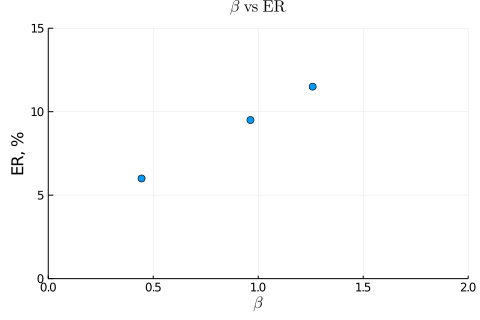

In [8]:
p1 = scatter( β,ERi_CAPM*100,
              xlim = (0,2),
              ylim = (0,15),
              legend = false,
              title = L"\beta \mathrm{\ vs \ ER}",
              xlabel = L"\beta",
              ylabel = "ER, %" )
display(p1)

# An Empirical Test of CAPM 

The next section performs an empirical test of CAPM. First, we load data. Second, we run linear regressions and test whether the intercept is zero (the CAPM prediction) or not.

## Loading Data

In [9]:
x    = readdlm("Data/FFmFactorsPs.csv",',',skipstart=1)
Rme  = x[:,2]                #market excess return
RSMB = x[:,3]                #small minus big firms
RHML = x[:,4]                #high minus low book-to-market ratio
Rf   = x[:,5]                #interest rate


x  = readdlm("Data/FF25Ps.csv",',') #no header line: x is matrix
R  = x[:,2:end]                     #returns for 25 FF portfolios
Re = R .- Rf                        #excess returns for the 25 FF portfolios
Re = Re[:,[1;7;13;19;25]]           #use just 5 assets to make the printing easier 

(T,n) = size(Re)                 #no. obs and  no. test assets

(388, 5)

## OLS Estimation and Testing α = 0

We now use the market return as a proxy for the tangency portfolio - and test if the model holds.

Recall: estimate $(\alpha_{i},b_{i})$ in the CAPM regression

$R_{it}^{e}  =\alpha_{i}+b_{i}R_{mt}^{e}+\varepsilon_{it}$

Test if $\alpha_{i}=0$.

In [10]:
x   = [ones(T) Rme]                   #regressors

α     = fill(NaN,n)
tstat = fill(NaN,n)
for i = 1:n                              #loop over the different test assets
    #local b_i, residual, Covb           #only needed in script
    (b_i,_,_,Covb,) = OlsGMFn(Re[:,i],x)
    α[i]            = b_i[1]                      #estimated α
    tstat[i]        = (b_i[1]-0)/sqrt(Covb[1,1])  #tstat of H₀: true α=0
end

printblue("OLS intercepts and t-stats:")
colNames = [string("asset ",i) for i=1:n]
rowNames = ["α","t-stat"]
printTable([α';tstat'],colNames,rowNames)

OLS intercepts and t-stats:
         asset 1   asset 2   asset 3   asset 4   asset 5
α         -0.504     0.153     0.305     0.279     0.336
t-stat    -1.656     1.031     2.471     2.163     2.073

